In [52]:
import torch
from datasets import load_dataset
import sys
import os
import tiktoken

utils_path = os.path.abspath(os.path.join(".."))
sys.path.insert(0, utils_path)
from utils import GPTDatasetFromTokens, create_dataloader_from_pt

In [53]:
# Load dataset 

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset = dataset["test"]
test_text = dataset["text"]
print(test_text[:5])

['', ' = Robert Boulter = \n', '', ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n', ' In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He

In [54]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": False        # Query-key-value bias
}

# Tokenize dataset

tokenizer = tiktoken.encoding_for_model("gpt2")
tokenized_text = tokenizer.encode("\n".join(test_text))
print(tokenized_text[:10])

[198, 796, 5199, 347, 2852, 353, 796, 220, 628, 198]


In [55]:
# Create dataloader

tokenized_text_tensor = torch.tensor(tokenized_text)
test_loader = create_dataloader_from_pt(
    token_tensor=tokenized_text_tensor,
    batch_size=4,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False,
)

In [56]:
from pathlib import Path
import torch
import numpy as np

gpt2_path = os.path.abspath(os.path.join(".."))
sys.path.insert(0, gpt2_path)
from gpt2 import GPTModel

file_path = "../model_checkpoints/"
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Load files from model_checkpoints

model_path = Path(file_path+"model_pg_final.pth")
learning_rates_path = Path(file_path+"learning_rates.txt")
tokens_seen_path = Path(file_path+"tokens_seen.txt")
train_losses = Path(file_path+"train_losses.txt")
val_losses = Path(file_path+"val_losses.txt")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load(model_path, map_location = device, weights_only=True))
model.eval()

# Load text files

learning_rates = np.loadtxt(learning_rates_path)
tokens_seen = np.loadtxt(tokens_seen_path)
train_losses = np.loadtxt(train_losses)
val_losses = np.loadtxt(val_losses)

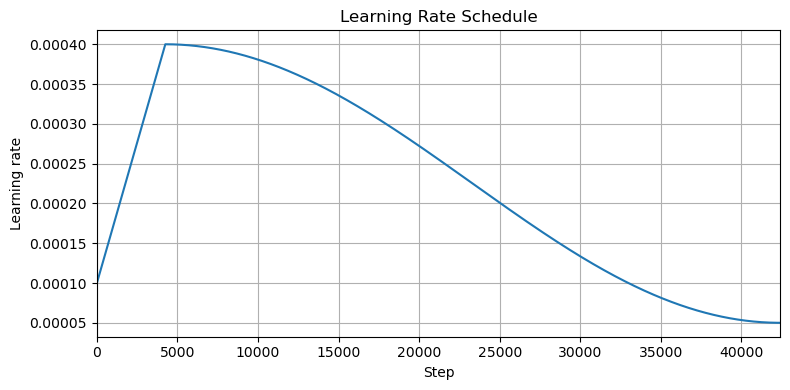

In [57]:
# Plotting the learning rates

import matplotlib.pyplot as plt

max_steps = 50000
steps = np.arange(len(learning_rates))

plt.figure(figsize=(8, 4))
plt.plot(steps, learning_rates, linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Learning Rate Schedule")
plt.xlim(0, min(max_steps, len(steps)))  # Cap x-axis at 50k or array length
plt.grid(True)
plt.tight_layout()
plt.show()

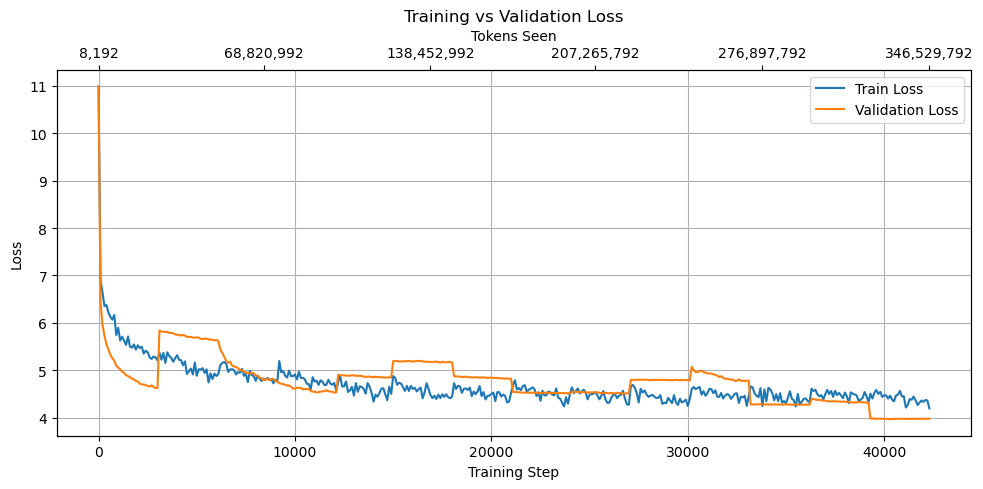

In [58]:
# Plotting train losses and validation losses 

logging_interval = 100
steps = np.arange(0, logging_interval * len(train_losses), logging_interval)

# Ensure tokens_seen array aligns in length
# If it's shorter or logged at a different interval, resample or interpolate
# Assuming tokens_seen was also logged every 100 steps
assert len(tokens_seen) == len(train_losses), "tokens_seen and train_losses must be same length"

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot losses on bottom x-axis (steps)
ax1.plot(steps, train_losses, label="Train Loss", linewidth=1.5)
ax1.plot(steps, val_losses, label="Validation Loss", linewidth=1.5)
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.grid(True)
ax1.legend()

# Create top x-axis for tokens seen
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Sync x-limits with step axis

# Set token ticks based on matching positions
token_tick_locs = np.linspace(0, len(tokens_seen) - 1, num=6, dtype=int)
token_tick_vals = tokens_seen[token_tick_locs]
step_tick_vals = steps[token_tick_locs]

ax2.set_xticks(step_tick_vals)
ax2.set_xticklabels([f"{int(tok):,}" for tok in token_tick_vals])
ax2.set_xlabel("Tokens Seen")

plt.tight_layout()
plt.show()

In [59]:
# Calculate perplexity of the model

total_loss = 0
total_tokens = 0
model.to(device)

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), targets.flatten(), reduction="sum")
        
        total_loss += loss.item()
        total_tokens += targets.numel()

avg_nll = total_loss / total_tokens
perplexity = np.exp(avg_nll)
print(perplexity)

3485.894768170674
